Import Libraries

# Loss Model
Here we will go through the steps of creating our loss model

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import seaborn as sns 
import matplotlib.pyplot as plt  


### Load Data

In [196]:
data = pd.read_excel('data/modelling_data.xlsx')
eval_data = pd.read_excel('data/evaluation_data.xlsx')


### Describe Data

In [168]:
print(data.describe())
print(data.head())

         deductible  claims_history  years_driving       loyalty  \
count  50000.000000     50000.00000    50000.00000  50000.000000   
mean    1110.050000         0.17040       20.70784      5.762600   
std      458.855324         0.59824       11.63238      3.367977   
min        0.000000         0.00000        0.00000      0.000000   
25%     1000.000000         0.00000       11.00000      3.000000   
50%     1000.000000         0.00000       21.00000      6.000000   
75%     1500.000000         0.00000       27.00000      8.000000   
max     2000.000000         5.00000       55.00000     22.000000   

       age_of_insured      car_year      exposure    claimcount  
count    50000.000000  50000.000000  5.000000e+04  50000.000000  
mean        39.915660   2009.598320  5.004006e-01      0.013080  
std         11.583736      8.947092  2.889492e-01      0.115018  
min         18.000000   1970.000000  1.406297e-07      0.000000  
25%         30.000000   2005.000000  2.486818e-01      0.

### Rename Columns

In [197]:
#Rename columns
data = data.rename(columns={'age_of_insured': 'Age', 'annual_mileage': 'Annual Mileage', 'winter_tires': 'Winter Tires', 'deductible': 'Deductible', 
                        'annual_income': 'Annual Income', 'ownership': 'Ownership', 'credit_band': 'Credit Band', 'gender': 'Gender', 'location': 'Location', 
                        'loyalty': 'Loyalty', 'marital_status': 'Marital Status', 'occupation': 'Occupation', 'vehicle_value': 'Vehicle Value', 
                        'car_year': 'Car Year', 'car_model': 'Car Model', 'claims_history': 'Claims History', 'years_driving': 'Years Driving'})

eval_data = eval_data.rename(columns={'age_of_insured': 'Age', 'annual_mileage': 'Annual Mileage', 'winter_tires': 'Winter Tires', 'deductible': 'Deductible', 
                        'annual_income': 'Annual Income', 'ownership': 'Ownership', 'credit_band': 'Credit Band', 'gender': 'Gender', 'location': 'Location', 
                        'loyalty': 'Loyalty', 'marital_status': 'Marital Status', 'occupation': 'Occupation', 'vehicle_value': 'Vehicle Value', 
                        'car_year': 'Car Year', 'car_model': 'Car Model', 'claims_history': 'Claims History', 'years_driving': 'Years Driving'})
    


### Exploratory Data Analysis

##### Histogram for Age of Insured

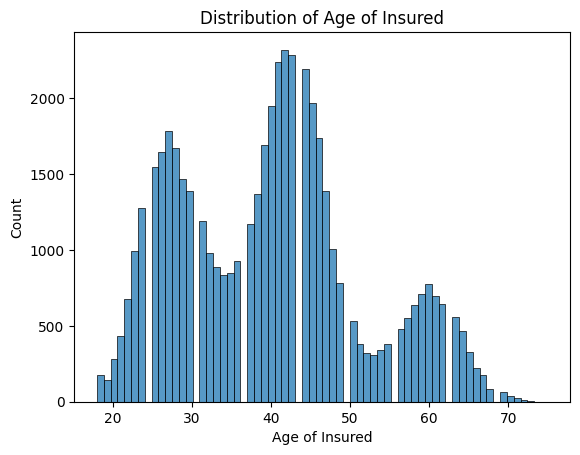

In [179]:

ax = sns.histplot(x='Age', data=data)
ax.set_title('Distribution of Age of Insured')
ax.set_xlabel('Age of Insured')
ax.set_ylabel('Count');


##### Analysis of Categorical Variables using a Multiplot

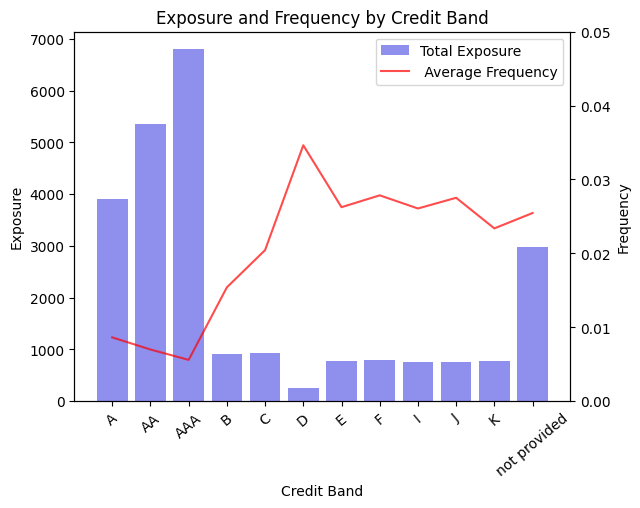

In [198]:
categorical_var = 'Credit Band'

#Select Data
grouped = data.groupby(categorical_var).agg(
    exposure=('exposure', 'sum'),
    frequency=('claimcount', 'mean')
).reset_index()

fig, ax = plt.subplots()

#Create Barplot for sum of exposure by categorical variable
sns.barplot(x=categorical_var, y = 'exposure', ax = ax, 
            color= 'blue', alpha = 0.5, label = 'Total Exposure', data=grouped)

#Create Lineplot for average frequency by categorical variable
ax2 = ax.twinx()
ax2.plot(grouped[categorical_var], grouped['frequency'], 
         color='red', alpha = 0.7, label=' Average Frequency')

ax2.set_ylim(0, 0.05)
#Set Labels
ax.set_title(f'Exposure and Frequency by {categorical_var}')
ax.set_xlabel(categorical_var)
ax.set_ylabel('Exposure')
ax2.set_ylabel('Frequency')
ax.tick_params(axis='x', labelrotation=40)

#Create Legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend_.remove()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right');

##### Feature Engineering

In [199]:
data.drop(['Marital Status', 'Occupation', 'Location', 'Gender', 'Loyalty', 'Car Model', 'Vehicle Value'], axis=1, inplace=True)
eval_data.drop(['Marital Status', 'Occupation', 'Location', 'Gender', 'Loyalty', 'Car Model', 'Vehicle Value'], axis=1, inplace=True)
categorical_columns = ['Annual Mileage', 'Winter Tires', 'Deductible', 'Annual Income', 'Ownership', 'Credit Band']


#Creating new features
data['Car Year'] = data['Car Year'] - 1970
data['Age'] = data['Age'] - 18
data['Deductible'] = data['Deductible'].astype(str)

eval_data['Car Year'] = eval_data['Car Year'] - 1970
eval_data['Age'] = eval_data['Age'] - 18
eval_data['Deductible'] = eval_data['Deductible'].astype(str)

target_column = 'claimcount'
exposure_column = 'exposure'


##### Train-Test Split

In [200]:
#Train-test split
initial_X_train, X_test, initial_y_train, y_test = train_test_split(
    data.drop(target_column, axis=1),
    data[target_column],
    test_size=0.2,
    random_state=42
)

#Prepare output
df = pd.DataFrame(X_test)

#Prepare training data
X_train = initial_X_train.copy()
y_train = initial_y_train.values
X_test = X_test.copy()






##### Preprocessing

In [201]:
#Add log-transformed exposure as a feature
X_train['log_exposure'] = np.log(X_train[exposure_column])
X_test['log_exposure'] = np.log(X_test[exposure_column])

#Separate numerical and categorical columns
numerical_columns = [col for col in X_train.columns if col not in categorical_columns + [exposure_column]]

#Scale numerical columns
scaler = MinMaxScaler()
X_train_scaled_numerical = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled_numerical = scaler.transform(X_test[numerical_columns])

#One-hot encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)  #Drop the base level for one-hot encoding
X_train_encoded_categorical = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded_categorical = encoder.transform(X_test[categorical_columns])

#Combine scaled numerical and encoded categorical features
X_train_prepared = np.hstack((X_train_scaled_numerical, X_train_encoded_categorical))
X_test_prepared = np.hstack((X_test_scaled_numerical, X_test_encoded_categorical))

X_train_prepared = sm.add_constant(X_train_prepared)
X_test_prepared = sm.add_constant(X_test_prepared)

##### Train and Test Model

In [ ]:
#Build model using poisson family
model = sm.GLM(y_train, X_train_prepared, family=sm.families.Poisson(), offset=X_train['log_exposure'].values)
result = model.fit()

#Use model to predict on the test set
offset_test = X_test['log_exposure'].values
y_pred = result.predict(X_test_prepared, offset=offset_test)

#Complete output
df['prediction'] = y_pred
df['claimcount'] = y_test
#df.to_excel('data/predictions_on_train_new.xlsx')

#Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE on Test Data: {rmse}')

RMSE on Test Data: 0.11173441727754026


##### Visualize Model Performance

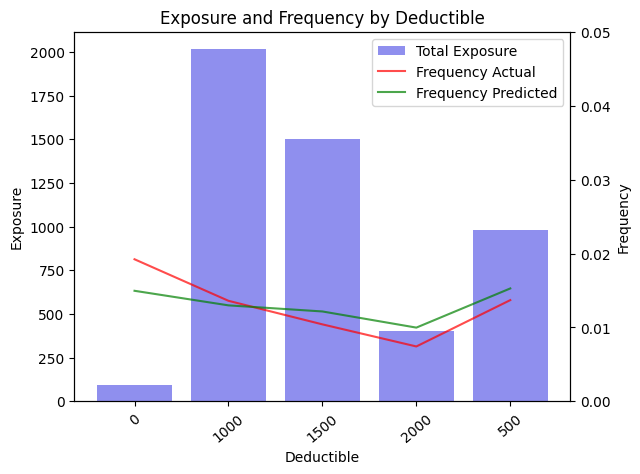

In [203]:
predictions = pd.read_excel('data/predictions_on_train_new.xlsx')
predictions['Deductible'] = predictions['Deductible'].astype(str)

categorical_var = 'Deductible'

#Select Data
grouped = predictions.groupby(categorical_var).agg(
    exposure=('exposure', 'sum'),
    frequency=('claimcount', 'mean'),
    frequency_predictions=('prediction', 'mean')
).reset_index()


fig, ax = plt.subplots()

#Create Barplot for sum of exposure by categorical variable
sns.barplot(x=categorical_var, y = 'exposure', ax = ax, 
            color= 'blue', alpha = 0.5, label = 'Total Exposure', data=grouped)

#Create Lineplot for average frequency by categorical variable
ax2 = ax.twinx()
ax2.plot(grouped[categorical_var], grouped['frequency'], 
         color='red', alpha = 0.7, label='Frequency Actual')


ax2.plot(grouped[categorical_var], grouped['frequency_predictions'], 
         color='green', alpha = 0.7, label='Frequency Predicted')

ax2.set_ylim(0, 0.05)

#Set Labels
ax.set_title(f'Exposure and Frequency by {categorical_var}')
ax.set_xlabel(categorical_var)
ax.set_ylabel('Exposure')
ax2.set_ylabel('Frequency')
ax.tick_params(axis='x', labelrotation=40)

#Create Legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend_.remove()


ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right');

### Make Predictions on Evaluation Set
Now that we are confident in our model, we can train on the whole dataset and predict on the evaluation set

In [ ]:

output_df = eval_data.copy()

#Prepare training data
X_train_final = data.drop(target_column, axis=1)
y_train_final = data[target_column].values
X_test_final = eval_data.copy()


#Preprocessing
#Add log-transformed exposure as a feature
X_train_final['log_exposure'] = np.log(X_train_final[exposure_column])
X_test_final['log_exposure'] = np.log(X_test_final[exposure_column])

#Separate numerical and categorical columns
numerical_columns = [col for col in X_train_final.columns if col not in categorical_columns + [exposure_column]]

#Scale numerical columns
scaler = MinMaxScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final[numerical_columns])
X_test_final_scaled = scaler.transform(X_test_final[numerical_columns])

#One-hot encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)  #Drop the base level for one-hot encoding
X_train_final_encoded = encoder.fit_transform(X_train_final[categorical_columns])
X_test_final_encoded = encoder.transform(X_test_final[categorical_columns])

#Combine scaled numerical and encoded categorical features
X_train_final_prepared = np.hstack((X_train_final_scaled, X_train_final_encoded))
X_test_final_prepared = np.hstack((X_test_final_scaled, X_test_final_encoded))

X_train_final_prepared = sm.add_constant(X_train_final_prepared)
X_test_final_prepared = sm.add_constant(X_test_final_prepared)



#Build model using poisson family
final_model = sm.GLM(y_train_final, X_train_final_prepared, family=sm.families.Poisson(), offset=X_train_final['log_exposure'].values)
final_result = final_model.fit()

#Use model to predict on the test set
offset_test = X_test_final['log_exposure'].values
y_pred_final = final_result.predict(X_test_final_prepared, offset=offset_test)

#Complete output
output_df['prediction'] = y_pred_final
#output_df.to_excel('data/predictions_on_evaluation.xlsx')

### Use Severity Model to Identify Top 5% Loss

In [4]:
severity = pd.read_excel('data/evaluation_severity.xlsx')
predictions = pd.read_excel('data/predictions_on_evaluation.xlsx')
predictions['loss'] = severity['Prediction'] * predictions['prediction']
predictions.to_excel('data/evaluation_with_loss.xlsx')

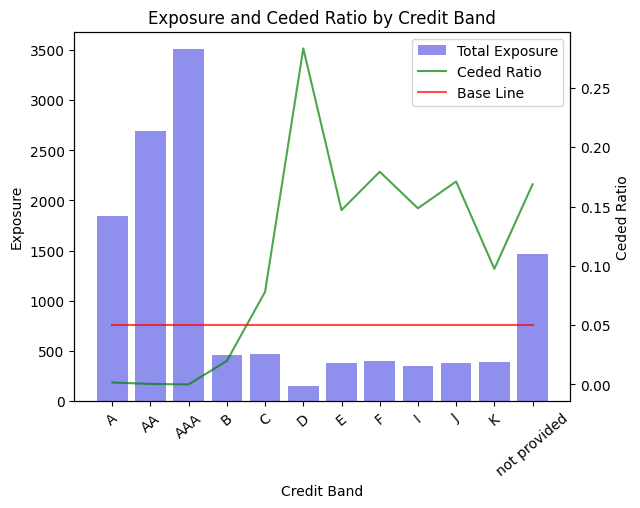

In [7]:
threshold = predictions['loss'].quantile(0.95)

# Step 2: Mark which rows are in the top 5%
predictions['top_5'] = predictions['loss'] >= threshold


categorical_var = 'Credit Band'

#Select Data
grouped = predictions.groupby(categorical_var).agg(
    exposure=('exposure', 'sum'),
    total_count=('loss', 'count'),
    top_5_count=('top_5', 'sum')
).reset_index()
grouped['ceded_ratio'] = grouped['top_5_count'] / grouped['total_count']
grouped['base_line'] = 0.05

fig, ax = plt.subplots()

#Create Barplot for sum of exposure by categorical variable
sns.barplot(x=categorical_var, y = 'exposure', ax = ax, 
            color= 'blue', alpha = 0.5, label = 'Total Exposure', data=grouped)

#Create Lineplot for average frequency by categorical variable
ax2 = ax.twinx()
ax2.plot(grouped[categorical_var], grouped['ceded_ratio'], 
         color='green', alpha = 0.7, label='Ceded Ratio')

ax2.plot(grouped[categorical_var], grouped['base_line'], 
         color='red', alpha = 0.7, label='Base Line')

# ax2.set_ylim(0, 1)
#Set Labels
ax.set_title(f'Exposure and Ceded Ratio by {categorical_var}')
ax.set_xlabel(categorical_var)
ax.set_ylabel('Exposure')
ax2.set_ylabel('Ceded Ratio')
ax.tick_params(axis='x', labelrotation=40)

#Create Legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend_.remove()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right');